In [200]:
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt

In [201]:
pd.options.display.max_rows = 20 # maximum number of rows to display

In [202]:
##conda install -c anaconda mysql-connector-python

In [203]:
##pip install pymysql

In [204]:
import pymysql

conn = pymysql.connect(database = 'sakila', user = 'root', password = '57575han')
cursor = conn.cursor()

In [205]:

query = "SHOW FULL TABLES;"
p = cursor.execute(query) 
tables = pd.read_sql(query,conn)
display(tables)

/Users/jinhanhan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Tables_in_sakila,Table_type
0,actor,BASE TABLE
1,actor_info,VIEW
2,address,BASE TABLE
3,category,BASE TABLE
4,city,BASE TABLE
...,...,...
18,sales_by_film_category,VIEW
19,sales_by_store,VIEW
20,staff,BASE TABLE
21,staff_list,VIEW


In [206]:
# Q. How much sales of each categories are present in 'film' table?
sales_by_catogory = pd.read_sql( """select * from sales_by_film_category order by total_sales DESC limit 7""", conn)
display(sales_by_catogory)

/Users/jinhanhan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,category,total_sales
0,Sports,5314.21
1,Sci-Fi,4756.98
2,Animation,4656.30
3,Drama,4587.39
4,Comedy,4383.58
5,Action,4375.85
6,New,4351.62


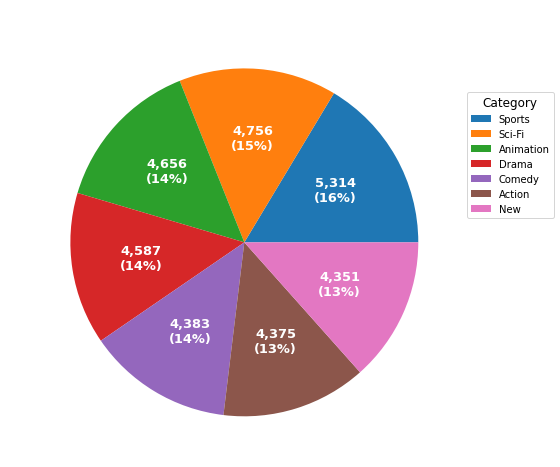

In [207]:
fig, ax = plt.subplots(figsize = (8,8))

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:,.0f}\n({:.0f}%)".format(absolute, pct)


wedges, texts, autotexts = ax.pie(sales_by_catogory["total_sales"],
       labels = sales_by_catogory["category"],
       autopct=lambda pct: func(pct, sales_by_catogory["total_sales"]),
       textprops=dict(color="w", fontsize = 13, fontweight = "bold"))
ax.legend(wedges, sales_by_catogory["category"],
          title="Category",
          fontsize = 10,
          loc="center left",
          bbox_to_anchor=(1, 0.2, 0.5, 1))
ax.set_title("Film Categories", fontsize = 15, color='#ffffff')
plt.rcParams['legend.title_fontsize'] = 12

plt.show()

In [208]:
#The average rental duration of films of each category

avg_rental_duration_category = pd.read_sql("""
SELECT category.category_id,category.name AS category_name, AVG(film.rental_duration) AS avg_rental_duration
FROM film JOIN film_category JOIN category ON film.film_id = film_category.film_id 
AND film_category.category_id = category.category_id GROUP BY category.category_id ORDER BY avg_rental_duration desc
""", conn)
display(avg_rental_duration_category)
print('Avg_rental_duration', np.mean(avg_rental_duration_category['avg_rental_duration']))

/Users/jinhanhan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,category_id,category_name,avg_rental_duration
0,16,Travel,5.3509
1,12,Music,5.2353
2,8,Family,5.1739
3,9,Foreign,5.1096
4,7,Drama,5.0806
5,4,Classics,5.0702
6,10,Games,5.0656
7,3,Children,5.0333
8,1,Action,4.9531
9,5,Comedy,4.9310


Avg_rental_duration 4.9916624999999994


In [216]:
#The most rental sales of films of each category and ratings

rental_sales_category = pd.read_sql("""
select category, sum(price), count(rental_id) FROM nicer_but_slower_film_list as film_info 
JOIN inventory JOIN rental ON film_info.FID = inventory.film_id AND inventory.inventory_id = rental.inventory_id 
GROUP BY category ORDER BY sum(price) desc limit 10;
""", conn)
print('Rental sales in catogories')
display(rental_sales_category)

rental_category_list = rental_sales_category['category'].tolist()
rental_duration_cat_list = avg_rental_duration_category['category_name'].tolist()

rental_price_category = rental_sales_category['sum(price)'].tolist()
avg_rental_category = avg_rental_duration_category['avg_rental_duration'].tolist()

rental_sales_category_list=[]
for i in range(len(rental_duration_cat_list)):
    for j in range(len(rental_category_list)):
        
        ##avg_duration * sum(rent_fee)
        if rental_duration_cat_list[i] == rental_category_list[j]:
            rental_sales_category_list.append(rental_price_category[j] * avg_rental_category[i])


rental_sales_category['total_rental_sales'] = rental_sales_category_list

print('Rental sales in catogories added total rental sales*rental durations')
display(rental_sales_category.sort_values(by=['total_rental_sales'], ascending=False))
            

/Users/jinhanhan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Rental sales in catogories


,category,sum(price),count(rental_id)
0,Sports,3557.33,1167
1,Sci-Fi,3289.99,1101
2,Drama,3288.57,1043
3,Animation,3218.34,1166
4,Comedy,3089.59,941
5,Foreign,3050.67,1033
6,Games,3033.31,969
7,Action,2966.88,1112
8,Family,2959.04,1096
9,New,2904.60,940


Rental sales in catogories added total rental sales*rental durations


,category,sum(price),count(rental_id),total_rental_sales
9,New,2904.60,940,16777.079746
2,Drama,3288.57,1043,16707.908742
7,Action,2966.88,1112,16072.259148
6,Games,3033.31,969,15750.234126
1,Sci-Fi,3289.99,1101,15587.703432
3,Animation,3218.34,1166,15365.535136
0,Sports,3557.33,1167,15309.777056
5,Foreign,3050.67,1033,15234.768290
4,Comedy,3089.59,941,14695.253328
8,Family,2959.04,1096,13785.231600


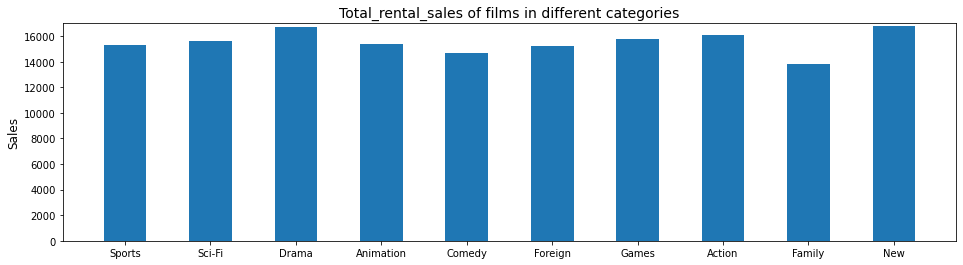

In [256]:
# bar chart of total_rental_sales

fig, ax = plt.subplots(figsize = (16,4))


ypos = np.arange(len(rental_sales_category["total_rental_sales"]))
bars = ax.bar(ypos, rental_sales_category["total_rental_sales"], width = 0.50)

ax.set_xticks(ypos)
ax.set_xticklabels(rental_sales_category["category"])

ax.set_ylim(ymax = 17000)

ax.set_title("Total_rental_sales of films in different categories", fontsize = 14)
ax.set_ylabel("Sales", fontsize = 12)

plt.show()


In [197]:

# The film table is a list of all films potentially in stock in the stores. The actual in-stock copies 
# of each film are represented in the inventory table.

# How many films of each rating are present in 'film' table?
film_ratings = pd.read_sql( """SELECT rating, COUNT(film_id) AS film_count FROM 
            film GROUP BY rating ORDER BY COUNT(film_id) DESC """, conn)
display(film_ratings)

/Users/jinhanhan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,rating,film_count
0,PG-13,223
1,NC-17,210
2,R,195
3,PG,194
4,G,178


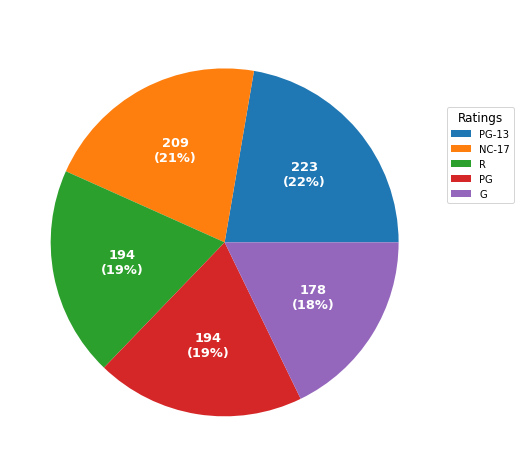

In [198]:

fig, ax = plt.subplots(figsize = (8,8))

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:,.0f}\n({:.0f}%)".format(absolute, pct)


wedges, texts, autotexts = ax.pie(film_ratings["film_count"],
       labels = film_ratings["rating"],
       autopct=lambda pct: func(pct, film_ratings["film_count"]),
       textprops=dict(color="w", fontsize = 13, fontweight = "bold"))
ax.legend(wedges, film_ratings["rating"],
          title="Ratings",
          fontsize = 10,
          loc="center left",
          bbox_to_anchor=(1, 0.2, 0.5, 1))
ax.set_title("Film Ratings", fontsize = 15, color='#ffffff')
plt.rcParams['legend.title_fontsize'] = 12

plt.show()

In [177]:
# acted number of films of actors 
sales_by_catogory = pd.read_sql( """SELECT first_name, last_name, COUNT(film_id) AS film_count FROM film_actor 
    JOIN actor ON actor.actor_id = film_actor.actor_id GROUP BY actor.actor_id 
    ORDER BY COUNT(film_id) DESC limit 10;""", conn)
display(sales_by_catogory)

/Users/jinhanhan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,first_name,last_name,film_count
0,GINA,DEGENERES,42
1,WALTER,TORN,41
2,MARY,KEITEL,40
3,MATTHEW,CARREY,39
4,SANDRA,KILMER,37
5,SCARLETT,DAMON,36
6,VAL,BOLGER,35
7,VIVIEN,BASINGER,35
8,GROUCHO,DUNST,35
9,UMA,WOOD,35


In [219]:
# Q. Which actors have performed films of all 16 categories?
# A. total 11 actors have worked in all 16 categories of films.

pd.read_sql("""
SELECT sub_table.actorid, actor.first_name, actor.last_name, sub_table.categories_cnt FROM actor JOIN (SELECT 
film_actor.actor_id AS actorid, COUNT(DISTINCT film_category.category_id) AS categories_cnt
FROM film_actor JOIN film JOIN film_category
ON film_actor.film_id = film.film_id AND film.film_id = film_category.film_id
GROUP BY film_actor.actor_id HAVING COUNT(DISTINCT film_category.category_id) >= 16) AS sub_table
ON actor.actor_id = sub_table.actorid
""", conn)

/Users/jinhanhan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,actorid,first_name,last_name,categories_cnt
0,13,UMA,WOOD,16
1,72,SEAN,WILLIAMS,16
2,95,DARYL,WAHLBERG,16
3,106,GROUCHO,DUNST,16
4,107,GINA,DEGENERES,16
5,127,KEVIN,GARLAND,16
6,139,EWAN,GOODING,16
7,155,IAN,TANDY,16
8,161,HARVEY,HOPE,16
9,185,MICHAEL,BOLGER,16


In [226]:
# What were the total sales per month?

total_m_sale = pd.read_sql("""SELECT DATE_FORMAT(payment_date, '%Y-%m') AS Date, ROUND(SUM(amount), 0) AS Sales 
FROM payment GROUP BY Date ORDER BY Date ASC;
""", conn)
display(total_m_sale)

/Users/jinhanhan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Date,Sales
0,2005-05,4823.0
1,2005-06,9630.0
2,2005-07,28369.0
3,2005-08,24070.0
4,2006-02,514.0


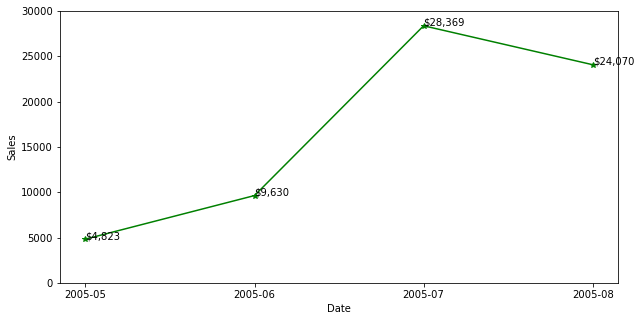

In [227]:
# line graph for total sales per month (EXCLUDING FEB-2006 SALES)

sales_per_month = total_m_sale.iloc[0:4].set_index("Date") # Excluding the 2006-02 sales

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(sales_per_month,"g*-")
ax.set_ylim(ymin = 0, ymax = 30000)
ax.set_ylabel("Sales")
ax.set_xlabel("Date")

for date, sales in sales_per_month["Sales"].items():
    ax.annotate(str("${:,.0f}".format(sales)),
                xy=(date, sales))

plt.show()

In [230]:
# Q. Make line graphs to compare monthly sales of each store.
# A. Since we now know that there is discontuinity of sales data from 2005-08 to 2006-02, we will exclude 2006-02 sales 
#    in the SQL query itself.

sale_per_store = pd.read_sql(
"""SELECT c.store_id AS store, DATE_FORMAT(sub_table.payment_date, '%Y-%m') AS stpd, ROUND(SUM(sub_table.amount),0) AS sales
FROM customer as c JOIN (SELECT customer_id, payment_date, amount FROM payment) AS sub_table
ON c.customer_id = sub_table.customer_id WHERE DATE_FORMAT(sub_table.payment_date, '%Y-%m') < '2006-01' 
GROUP BY c.store_id, stpd
ORDER BY c.store_id, stpd;""", conn)

display(sale_per_store)

/Users/jinhanhan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,store,stpd,sales
0,1,2005-05,2695.0
1,1,2005-06,5149.0
2,1,2005-07,15735.0
3,1,2005-08,13136.0
4,2,2005-05,2129.0
5,2,2005-06,4481.0
6,2,2005-07,12634.0
7,2,2005-08,10934.0


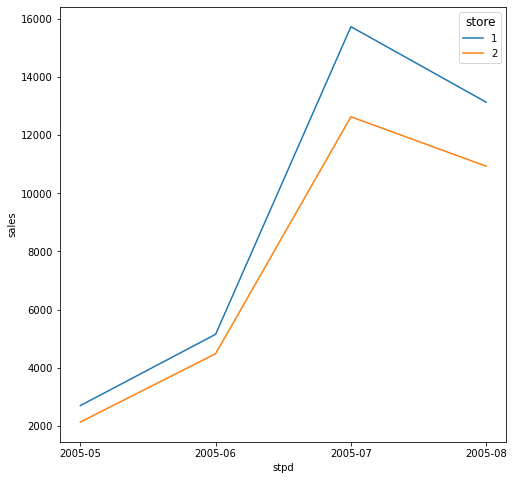

In [232]:
plt.subplots(figsize=(8, 8))
sns.lineplot(data = sale_per_store, x="stpd", y="sales", hue="store", palette="tab10", )
plt.show()

In [236]:

# Q. Make pivot table for monthly sales of the stores.
sales_store = pd.read_sql("""SELECT DATE_FORMAT(sub_table.payment_date, '%Y-%m') AS Date, 
    c.store_id AS store, sub_table.amount AS sales_data 
    FROM customer c JOIN (SELECT customer_id, payment_date, amount FROM payment) AS sub_table
    ON c.customer_id = sub_table.customer_id;""", conn)
display(sales_store)

/Users/jinhanhan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Date,store,sales_data
0,2005-05,1,2.99
1,2005-05,1,0.99
2,2005-06,1,5.99
3,2005-06,1,0.99
4,2005-06,1,9.99
...,...,...,...
16039,2005-08,2,4.99
16040,2005-08,2,1.99
16041,2005-08,2,8.99
16042,2005-08,2,2.99


In [238]:
pivottable = pd.pivot_table(sales_store, index=sales_store['Date'], columns=sales_store['store'], aggfunc=np.sum)
display(pivottable)

sales_data          
store            1         2
Date                        
2005-05    2694.62   2128.82
2005-06    5148.57   4481.32
2005-07   15735.23  12633.68
2005-08   13136.09  10934.05
2006-02     283.02    231.16

In [243]:
# Q. What are the 5 'G' rated films that have lowest replacement cost and atmost 3 copies of itself in the inventory?

pd.read_sql("""
SELECT DISTINCT f.film_id, f.title, replacement_cost, COUNT(i.film_id) AS copies_in_inv
FROM film f JOIN inventory i ON f.film_id = i.film_id
WHERE rating = 'G' GROUP BY f.film_id, f.title HAVING copies_in_inv <= 3 ORDER BY replacement_cost LIMIT 5
""", conn)



/Users/jinhanhan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,film_id,title,replacement_cost,copies_in_inv
0,996,YOUNG LANGUAGE,9.99,2
1,182,CONTROL ANTHEM,9.99,2
2,959,WARLOCK WEREWOLF,10.99,2
3,692,POTLUCK MIXED,10.99,3
4,612,MUSSOLINI SPOILERS,10.99,2


/Users/jinhanhan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


<AxesSubplot:>

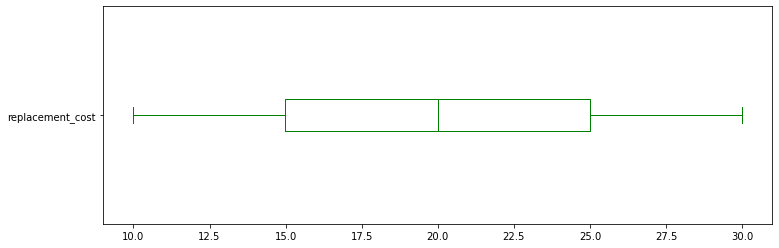

In [244]:
# Q. Make Boxplot of replacement_cost of films

replacement_c = pd.read_sql("""    
SELECT 
    replacement_cost
    FROM film    
""", conn)

# making boxplot for replacement_c
replacement_c.boxplot(color='g', vert=False, grid=False, figsize=(12,4))

/Users/jinhanhan/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


<AxesSubplot:title={'center':'replacement_cost'}, xlabel='[rating]'>

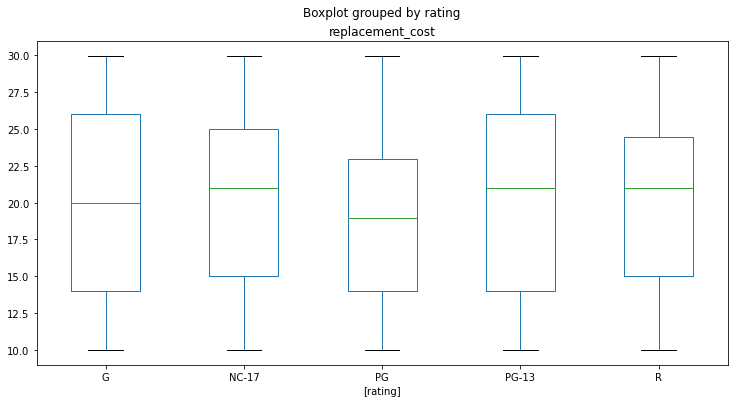

In [246]:
# Q. Make boxplots for replacement cost of films of different ratings

replacement_c_rating = pd.read_sql("""SELECT rating, replacement_cost FROM film""", conn)

# making boxplot for replacement_c_rating
replacement_c_rating[['replacement_cost' , 'rating']].boxplot(by='rating', figsize=(12,6), grid=False)